## 1. Transformer와 비교해 변경이 필요한 부분

1. 인코더, 인코더와 연결된 디코더 블럭의 크로스 어텐션 부분을 삭제한다.
2. 포지셔널 인코딩 부분을 포지셔널 임베딩으로 변경한다.
3. input을 traversal-style로 변환한다.
4. softmax에 임베딩 행렬을 점곱한다.

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    output = tf.matmul(attention_weights, value)
    return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                     (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [5]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]

    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)

    return tf.maximum(look_ahead_mask, padding_mask)

In [19]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 인코더 아웃풋을 더이상 받지 않음
    #enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    look_ahead_mask = tf.keras.Input(shape=(1,None,None), name="look_ahead_mask")
    
    # padding mask는 크로스어텐션에서 사용하므로, 제거한다.
    #padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1+inputs)
    
    # 인코더와 연결되었던 attention2 제거, attention1만 사용
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention1)
    
    return tf.keras.Model(
        # 인코더 아웃풋과 패딩마스크를 더이상 input으로 받지 않는다.
        #inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [479]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_length, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # 인코더 아우풋을 더이상 받지 않음.
    #enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    # 패딩마스크를 더이상 받지 않음.
    #padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩 -> 포지셔널 임베딩
    #embeddings = PositionalEncoding(max_legnth, d_model)(embeddings)
    
    # 포지셔널 임베딩 추가
    position_indices = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
    position_embeddings = tf.keras.layers.Embedding(
        input_dim=max_length,  # 최대 시퀀스 길이
        output_dim=d_model
    )(position_indices)

    # 워드 임베딩 + 포지셔널 임베딩
    embeddings += position_embeddings
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units = units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            # 인코더 아웃풋 제거
            #)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        )(inputs=[outputs, look_ahead_mask])
        
    return tf.keras.Model(
        # 인코더 아웃풋과 패딩마스크를 더이상 input으로 받지 않는다.
        #inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [526]:
path_to_dataset = "./ChatbotData.csv"
dataframe = pd.read_csv(path_to_dataset)
dataframe.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [527]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]', ' ', sentence)
    sentence = re.sub(r'(.)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [528]:
questions = dataframe['Q'].apply(preprocess_sentence)
answers = dataframe['A'].apply(preprocess_sentence)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [529]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

#START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]
START_TOKEN, DELIMITER_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1], [tokenizer.vocab_size+2]

VOCAB_SIZE = tokenizer.vocab_size + 3

MAX_LENGTH = 80

In [530]:
sample_string = questions[20]

tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 문장 [5851, 588, 3506, 130, 696, 3742, 832]
기존 문장: 가스비 비싼데 감기 걸리겠어
5851 ----> 가스
588 ----> 비 
3506 ----> 비싼
130 ----> 데 
696 ----> 감기 
3742 ----> 걸리
832 ----> 겠어


In [531]:
"""def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs"""

def tokenize_and_filter(questions, answers):
    sequences = []
    before_list = []
    for (sentence1, sentence2) in zip(questions, answers):
        # delimiter 전까지의 토큰 길이 저장
        before_deli = START_TOKEN + tokenizer.encode(sentence1)
        # q + a 합쳐서 인코딩
        encoded = START_TOKEN + tokenizer.encode(sentence1) + DELIMITER_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        if len(encoded) <= MAX_LENGTH:
            sequences.append(encoded)
            before_list.append(len(before_deli))
    # 패딩
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=MAX_LENGTH, padding='post')
    # 질문 부분을 마스킹
    masks = np.ones((len(sequences), MAX_LENGTH), dtype = np.float32)
    for i, x in enumerate(before_list):
        masks[i, :x] = 0
    masked = padded * masks
    
    return padded[:, :-1], masked[:, 1:]

In [532]:
questions, answer = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

print(questions[0])
print(answers[0])

단어장의 크기 : 8478
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823
[8475 8214 1408 3058 8476 3845   66 8194 8477    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
하루가 또 가네요


In [533]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        # dataset에서도 inputs가 필요 없어짐.
        #'inputs': questions,
        'dec_inputs': questions
    },
    {
        'outputs': answer
    }))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [534]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, max_length, name='transformer'):
    # 인코더 인풋은 받지 않음.
    #inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더 패딩도 받지 않음.
    """# 인코더 패딩
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape = (1, 1, None),
        name='enc_padding_mask')(inputs)"""
    # 디코더 패딩, 셀프어텐션부분
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # 크로스 어텐션도 받지 않음.
    """# 디코더 패딩, 크로스어텐션부분
    # dec_padding_mask의 input이 인코더패딩의 input과 같은 이유?
    # 디코더의 크로스 어텐션 레이어가 인코더 출력의 패딩 토큰을 무시하기 위해 필요하기 때문
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)"""
    
    """# 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        max_legnth=max_length)(inputs=[inputs, enc_padding_mask])"""
    
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        max_length=max_length)(inputs=[dec_inputs, look_ahead_mask])
    # 인코더 아웃풋과 패딩마스크를 더이상 input으로 받지 않는다.
    #(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    # 인코더 인풋풋을 더이상 input으로 받지 않는다.
    #return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
    return tf.keras.Model(inputs=[dec_inputs], outputs=outputs, name=name)

In [535]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
MAX_LENGTH = 80

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_length = MAX_LENGTH)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    4299264     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8478)   2178846     decoder[0][0]          

In [536]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask  = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

In [537]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [538]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [539]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 20s 86ms/step - loss: 0.7253 - accuracy: 0.0130
Epoch 2/20
185/185 [==============================] - 16s 88ms/step - loss: 0.5787 - accuracy: 0.0253
Epoch 3/20
185/185 [==============================] - 17s 89ms/step - loss: 0.4897 - accuracy: 0.0256
Epoch 4/20
185/185 [==============================] - 16s 88ms/step - loss: 0.4524 - accuracy: 0.0277
Epoch 5/20
185/185 [==============================] - 16s 87ms/step - loss: 0.4253 - accuracy: 0.0293
Epoch 6/20
185/185 [==============================] - 16s 87ms/step - loss: 0.3969 - accuracy: 0.0311
Epoch 7/20
185/185 [==============================] - 16s 88ms/step - loss: 0.3657 - accuracy: 0.0339
Epoch 8/20
185/185 [==============================] - 16s 88ms/step - loss: 0.3315 - accuracy: 0.0377
Epoch 9/20
185/185 [==============================] - 16s 88ms/step - loss: 0.2936 - accuracy: 0.0419
Epoch 10/20
185/185 [==============================] - 16s 88ms/step - loss: 0.253

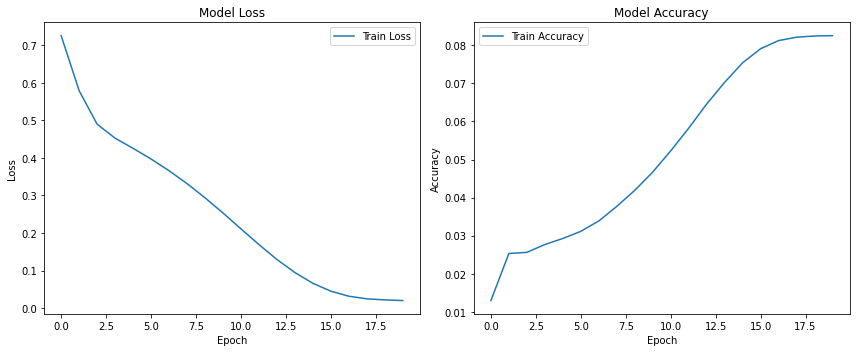

In [540]:
# 학습 과정 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

인퍼런스 모델에서 input을 sentence를 제거.

In [541]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(
          START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        #predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = model(inputs=[output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [542]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [543]:
sentence_generation("영화 뭐 좋아해?")

입력 : 영화 뭐 좋아해?
출력 : 가끔은 힘내지 말고 내려오세요


'가끔은 힘내지 말고 내려오세요'

In [546]:
sentence_generation("사랑해")

입력 : 사랑해
출력 : 가끔은 힘내지 말고 내려오세요


'가끔은 힘내지 말고 내려오세요'